##Distribuição geoespacial de aeroportos

O objetivo do problema consiste na utilização de um algoritmo de *clustering* para a determinação dos melhores pontos geoespaciais para a construção de três aeroportos em Belém.

####Módulos

In [ ]:
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

####*Database* de localidades dos bairros + constantes utilizadas

In [ ]:
neighborhood_list_url = "https://raw.githubusercontent.com/EudeMonteiro/Inteligencia-Artificial/" \
                        "main/Trabalho_III_Clusterizacao/lista_de_bairros.csv"

df_neighborhoods = pd.read_csv(neighborhood_list_url)

# Coordenadas do aeroporto Val-de-Cans
VAL_DE_CANS_COORDS = [-1.3856314207998055, 
                      -48.479838522605164]

# Número máximo de iterações a serem 
# realizadas pelo algoritmo K-Means
NUM_ITR = 200

In [ ]:
def kmeans():
    '''
    Função que implementa o algoritmo K-Means

    Retorna:

    - centroid_points: coordenadas dos centróides da melhor solução encontrada
    - df: DataFrame com informações dos bairros + o cluster a qual pertencem
    '''
    
    df = df_neighborhoods.copy(deep=True)
    centroid_points = df.sample(3)[["Latitude", "Longitude"]].values.tolist()
    centroid_points.append(VAL_DE_CANS_COORDS)
    i=1 

    while i <= NUM_ITR:
        for neighborhood in df_neighborhoods.values.tolist():
            
            distances_to_centroids = []
            coordinates = neighborhood[2:4] # Seleção das features 
                                            # "Latitude" e "Longitude"
                    
            for point in centroid_points:
                # Cálculo da distância euclidiana de 
                # um dado ponto para todos os centróides
                dist = np.linalg.norm(np.array(coordinates) - np.array(point))
                distances_to_centroids.append(dist)

            # Agregação dos bairros ao cluster com centróide mais próximo
            df.loc[(df["Latitude"] == coordinates[0]) &
                   (df["Longitude"] == coordinates[1]), "Cluster"] = np.argmin(distances_to_centroids)

        # Salva as localizações atuais dos 
        # centróides para compará-las com as novas
        curr_centroid_points = centroid_points

        # Atualização das coordenadas dos centróides  
        centroid_points = [list(df.loc[df["Cluster"] == j, ["Latitude", "Longitude"]].mean()) for j in range(3)]
        centroid_points.append(VAL_DE_CANS_COORDS)

        # Caso as posições dos centróides não tenham se alterado 
        # de uma iteração para outra, o algoritmo deve parar
        if centroid_points == curr_centroid_points:
            break
                    
        i+=1

    return np.array(centroid_points), df

In [ ]:
def plot_clustering_graph(centroid_points: list, 
                          df: pd.DataFrame,
                          title: str) -> None:

    """
    Plota o gráfico que ilustra a clusterização
    dos bairros realizada pelo algoritmo K-Means
    
    Parâmetros:
    - centroid_points: lista das coordenadas dos centróides
    - df: DataFrame com informações dos bairros + o cluster a qual pertencem
    - title: Título do gráfico plotado
    """

    K = 4 # Número de clusters
    cluster_colors = ['#b11747', '#fa9857', '#62bda7', '#4e63ac']
    
    for n in range(K):
        data = df[df["Cluster"] == n]
        plt.scatter(data["Longitude"], data["Latitude"], 
                    c=cluster_colors[n], label=f"Cluster {n+1}")        

    for index, names in df.iterrows():
        plt.annotate(names["Bairros"].replace(" ", "\n"), 
                     (names["Longitude"], names["Latitude"]), 
                     xytext=(4,3), textcoords='offset points', fontsize=3)
    
    
    plt.scatter(centroid_points[:,1], centroid_points[:,0], 
                edgecolor='orange', marker= "h", 
                s=50, c="black", label="Aeroporto")
    
    plt.title(title)
    plt.xlabel("Longitude", labelpad=10)
    plt.ylabel("Latitude", labelpad=10)

    plt.grid(linestyle='--', linewidth=0.5)
    plt.legend(loc='upper left', shadow=True, fontsize='small')
    plt.rcParams['figure.figsize']= (6,6)
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['axes.axisbelow'] = True
    plt.tight_layout()
    plt.show()

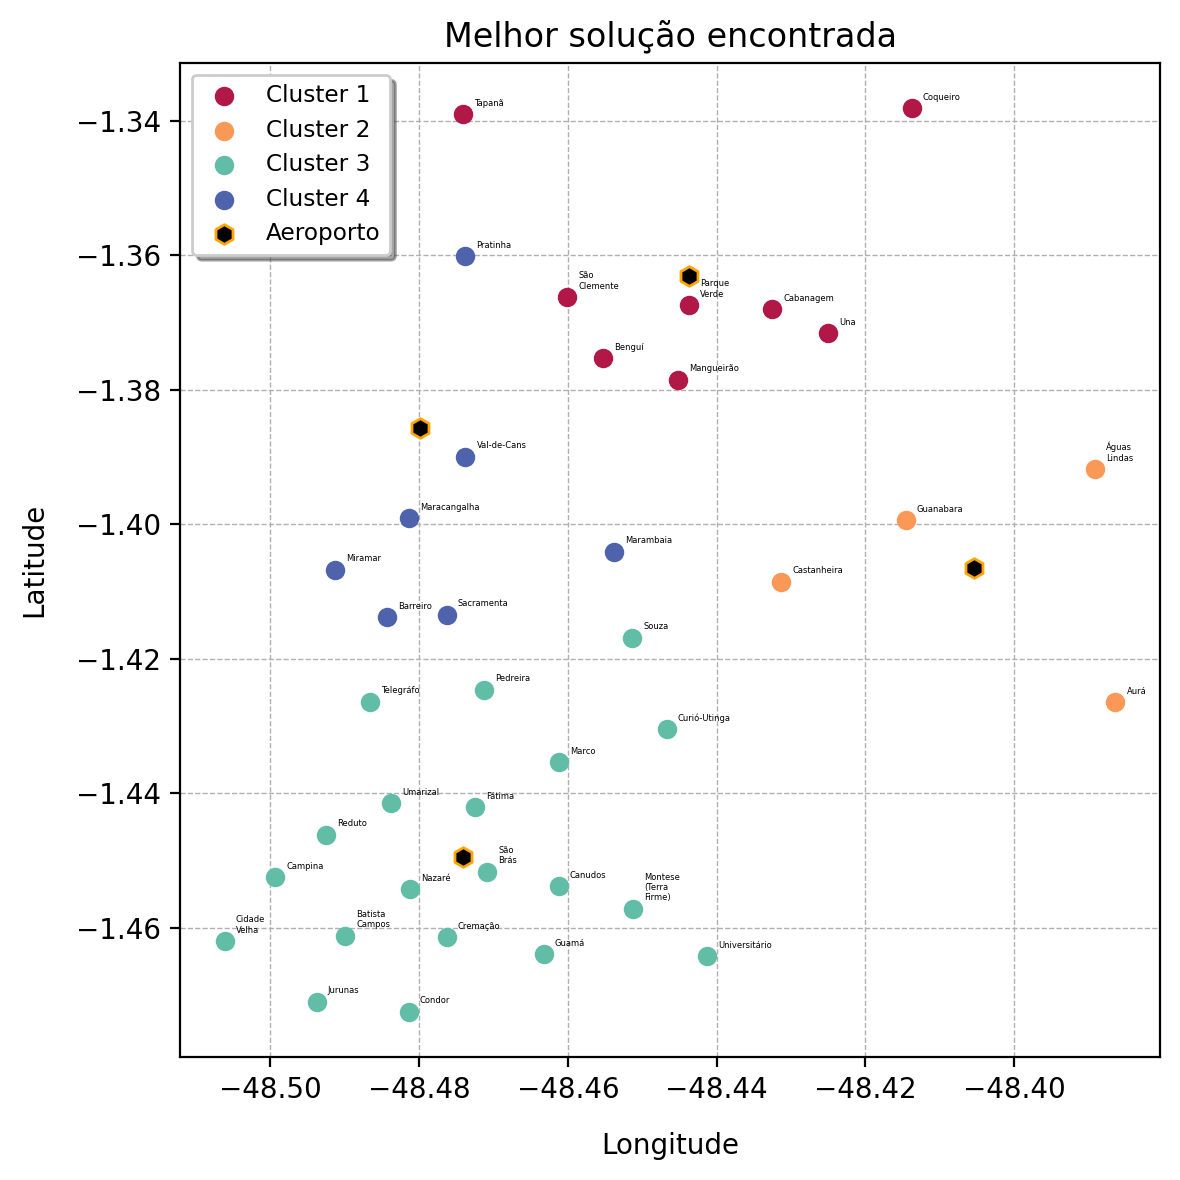

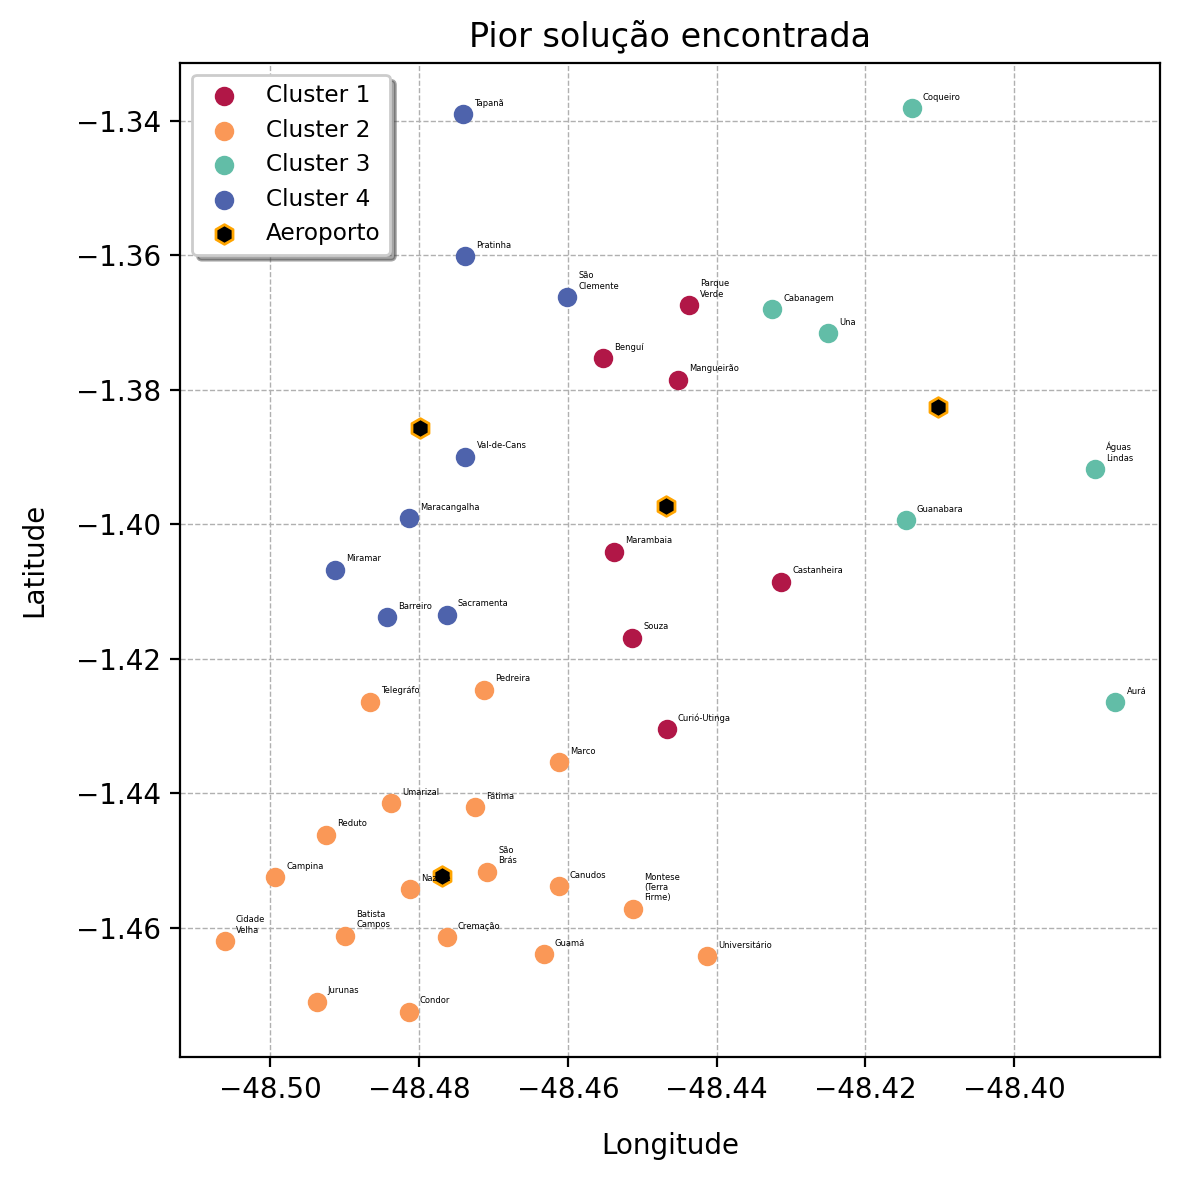

In [ ]:
def compute_minimum_total_distance():
    """
    Realiza um teste de 20 execuções do 
    algoritmo K-Means, calculando a distância 
    total dos bairros até o aeroporto mais próximo
    em cada uma delas

    Retorna:

    best_solution: Lista com informações relativas à melhor solução encontrada
    worst_solution: Lista com informações relativas à pior solução encontrada
    """
    executions_data = []

    for execution_num in range(1, 20+1):
        centroid_points, df = kmeans()
        nearest_airport_distance = []
        
        for cluster in range(4):
            
            nearest_centroid = centroid_points[cluster]
            cluster_elements = df.loc[df["Cluster"] == cluster]
            
            for _, coordinates in cluster_elements[["Latitude", "Longitude"]].iterrows():
                vector_diff = coordinates - nearest_centroid
                
                #Cálculo do produto escalar (distância Euclidiana absoluta)
                nearest_airport_distance.append(vector_diff @ vector_diff)

        executions_data.append([centroid_points, df, 
                                sum(nearest_airport_distance)])

    best_solution = min(executions_data, key=lambda x: x[2])
    worst_solution = max(executions_data, key=lambda x: x[2])

    return best_solution, worst_solution



if __name__ == '__main__':

    best_solution, worst_solution = compute_minimum_total_distance()
                    
    plot_clustering_graph(best_solution[0], best_solution[1], "Melhor solução encontrada")
    print()
    plot_clustering_graph(worst_solution[0], worst_solution[1], "Pior solução encontrada")